<h1><center>STAT-542 HW5</center></h1>
Sharvi Tomar (stomar2)

## About HW5

We utilize the coordinate descent algorithm introduced in the class to implement the entire Lasso solution. For coordinate descent, you may also want to review HW4. This HW involves two steps: in the first step, we solve the solution for a fixed $\lambda$ value, while in the second step, we consider a sequence of $\lambda$ values and solve it using the path-wise coordinate descent. 

## Question 1 [50 Points] Lasso solution for fixed $\lambda$ 

For this question, you cannot use functions from any additional library, except the `MASS` package, which is used to generate multivariate normal data. Following HW4, we use the this version of the objective function: 

$$\arg\min_{\beta} \frac{1}{n} \lVert \mathbf{y} - \mathbf{X}\beta \rVert^2 + \lambda \lVert \beta \rVert_1$$

The following data is used to fit this model. You can consider using similar functions in Python if needed. We use 

In [174]:
import random
import math
import numpy as np
from sklearn.preprocessing import MinMaxScaler

random.seed(24)
n = 100
p = 200
lambda_val = 0.3

# covariance matrix
V = np.array([[0.3] * p] * p)
np.fill_diagonal(V, [1] * p)

X_org = np.random.multivariate_normal(mean =[0]*p, cov=V, size=(n))
true_b = list(range(1,4)) + list(range(-3,0)) + [0] * (p-6)
y_org = np.matmul(X_org, true_b) + np.random.normal(0, 1, n)

# transformation of X_org
sd_X = np.std(X_org, axis=0)
mean_X = np.mean(X_org, axis=0)

# transformation of y_org
sd_y = np.std(y_org)
mean_y = np.mean(y_org)
              
X = ((X_org - mean_X)/sd_X) * math.sqrt(n/(n-1))
y = ((y_org - mean_y)/sd_y) * math.sqrt(n/(n-1))

a) [10 pts] State the solution $x$ of the following problem

$$
\underset{x}{\arg \min}\,\, (x-b)^{2}+\lambda|x|, \quad \lambda>0
$$

Then, implement a function in the form of `soft_th <- function(b, lambda)` to return the result of the above problem. Note in the coordinate descent discussed in the slides,  where $b$ is an OLS estimator, and $\lambda$ is the penalty parameter. Report the function output for the following testing cases with $\lambda = 0.3$: 1) $b = 1$; 2) $b = -1$; 3) $b = -0.1$.


In [175]:
beta = [1, -1 ,-0.1]
lambda_val = 0.3

def soft_th(b, lambda_val):
    if b > lambda_val/2: return b - lambda_val/2
    elif b < -lambda_val/2: return b + lambda_val/2
    else: return 0

for i in beta:
    print("Soft threshold function output for lambda = 0.3 & OLS value of", i,"is:", soft_th(i, lambda_val))

Soft threshold function output for lambda = 0.3 & OLS value of 1 is: 0.85
Soft threshold function output for lambda = 0.3 & OLS value of -1 is: -0.85
Soft threshold function output for lambda = 0.3 & OLS value of -0.1 is: 0


b) [40 pts] We will use the pre-scale and centered data `X` and `y` for this question, hence no intercept is needed. Write a Lasso algorithm function `myLasso(X, y, lambda, beta_init, tol, maxitr)`,  which return two outputs (as a list with two components): 
  
    * a vector of $\beta$ values **without** the intercept 
    * number of iterations
    
    You need to consider the following while completing this question:

    * Do not use functions from any additional library
    * Start with a vector `beta_init`: $\boldsymbol \beta = \mathbf{0}_{p \times 1}$
    * Use the soft-threshold function in the iteration when performing the coordinate-wise update. 
    * Use the efficient $\mathbf{r}$ updating appraoch (we discussed this in lecture and HW4) in the iteration
    * Run your coordinate descent algorithm for a maximum of `maxitr` = 100 iterations. Each iteration should loop through all variables. 
    * You should implement the early stopping rule with `tol`. This means terminating the algorithm when the $\boldsymbol \beta$ value of the current iteration is sufficiently similar to the previous one, i.e., $\lVert \boldsymbol \beta^{(k)} - \boldsymbol \beta^{(k-1)} \rVert^2 \leq \text{tol}$. 

    Aftering completing your code, run it on the data we generated previously. Provide the following results: 
    
    - Print out the first 8 coefficients and the number of iterations.
    - Check and compare your answer to the `glmnet` package using the following code. You should report their __first 8 coefficients__ and the $L_1$ norm of the difference $\| \, \hat{\boldsymbol\beta}^\text{glment}_{[1:8]} - \hat{\boldsymbol\beta}^\text{yours}_{[1:8]} \, \|_1$. 

In [331]:
def myLasso(X, y, lambda_val, beta_init, tol, maxitr):
    beta_new = beta_init
    XcolNorm = np.sum(X**2, axis=0)
    iters =0
    n = X.shape[0]
    
    for k in range(maxitr): 
        iters +=1
        beta_init = beta_new
        r = y - np.dot(X, beta_init)
        
        for j in range(X.shape[1]):
            r += (X[:, j] * beta_new[j])
            
            ## soft threshold function
            beta_new[j] = soft_th(np.dot(X[:, j].T, r)/ XcolNorm[j], lambda_val*n/XcolNorm[j])
            #print("shape of returned beta", len(beta_new[j]))
            r -= (X[:, j] * beta_new[j])
            
        ## early stopping criteria  
        #if sum([(a_i - b_i)**2 for a_i, b_i in zip(beta_new, beta_init)]) <= tol: break  
            
    return[beta_new, iters] 

In [332]:
ret = myLasso(X, y, lambda_val, beta_init = [0] * p, tol = 1e-20, maxitr = 100)
print("First 8 coefficients are:",ret[0][:8])
print("Number of iterations:",ret[1])

First 8 coefficients are: [0, 0.236616702453988, 0.4471718631762617, -0.47456293083160617, -0.12949794901485467, -0.06380806243309806, 0, 0]
Number of iterations: 100


In [334]:
len(ret[0])

200

In [320]:
from sklearn.linear_model import Lasso
import math 
model = Lasso(alpha= lambda_val/2,fit_intercept = False)
model.fit(X, y)
sklearn_lasso_coef = model.coef_
print("First 8 coefficients of sklearn_lasso are:", sklearn_lasso_coef[:8])
print("First 8 coefficients of myLasso are:", ret[0][:8])
print("L1 norm of their difference is:",sum([abs(a_i - b_i) for a_i, b_i in zip(sklearn_lasso_coef[:8], ret[0][:8])]) )

First 8 coefficients of sklearn_lasso are: [ 0.          0.23661336  0.4471632  -0.4745672  -0.12949271 -0.06380515
  0.          0.        ]
First 8 coefficients of myLasso are: [0, 0.236616702453988, 0.4471718631762617, -0.47456293083160617, -0.12949794901485467, -0.06380806243309806, 0, 0]
L1 norm of their difference is: 2.4429279537774296e-05


## Question 2 [50 Points] Path-wise Coordinate Descent

Let's perform path-wise coordinate descent. The idea is simple: we will solve the solution on a sequence of $\lambda$ values, starting from the largest one in the sequence. The first initial $\boldsymbol\beta$ are still all zero. After obtaining the optimal $\boldsymbol \beta$ for a given $\lambda$, we simply use this solution as the initial value for the next, smaller $\lambda$. This is referred to as a __warm start__ in optimization problems. We will consider the following sequence of $\lambda$ borrowed from `glmnet`. Note that this is a decreasing sequence from large to small values.


In [321]:
import pandas as pd
lamda_all_df = pd.read_csv("data.csv")
lamda_all = lamda_all_df.to_numpy()
lamda_all.shape

(100, 1)

In [322]:
#Run lasso regression for each lambda
theta_list = []
for i in range(len(lamda_all)):
    model = Lasso(alpha = lamda_all[i][0], fit_intercept = False)
    model.fit(X, y)
    theta_list.append(model.coef_)

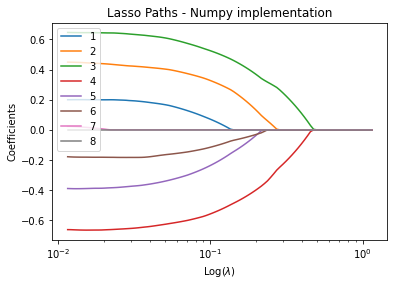

In [323]:
#Stack into numpy array
theta_lasso = np.stack(theta_list).T

for i in range(8):
    plt.plot(lamda_all, theta_lasso[i], label = i+1)

plt.xscale('log')
plt.xlabel('Log($\\lambda$)')
plt.ylabel('Coefficients')
plt.title('Lasso Paths - Numpy implementation')
plt.legend()
#plt.axis('tight')

a) [20 pts] Write a function `myLasso_pw <- function(X, y, lambda_all, tol, maxitr)`, which output a $p \times N_{\lambda}$ matrix. $N_{\lambda}$ is the number of unique $\lambda$ values. Also follow the above instruction at the beginning of this question to include the **warm start** for path-wise solution. Your `myLasso_pw` should make use of your `myLasso` in Question 1.

In [381]:
def myLasso_pw(X, y, lamda_all, tol, maxitr):
    beta_init = [0] * p
    #beta_vals = [[0] * p] * 100
    ret = []
    #beta_temp = [0]*len(lamda_all)
    beta_temp = []
    
    #beta_temp[0] =  myLasso(X, y, lamda_all[0][0], beta_init, 1e-7, 100)[0]
    #beta_vals[0] = beta_temp[0]
    
    beta_temp.append(myLasso(X, y, lamda_all[0][0], beta_init, 1e-7, 100)[0])
    #ret.append(beta_temp[0])
    
    for i in range(1,len(lamda_all)):
        print("betas",beta_temp)  
        #beta_temp[i] =  myLasso(X, y, lamda_all[i][0], beta_temp[i-1], 1e-7, 100)[0]
        
        beta_temp.append(myLasso(X, y, lamda_all[i][0], beta_temp[-1], 1e-7, 100)[0])
        #beta_vals[i] = beta_temp[i]
        #ret.append(beta_temp[i])
               
          
        #print("ret inside", ret)
        #print("beta_val", beta_vals)
    return beta_temp[-1]
    #return ret


In [382]:
b1_mylasso_pw = myLasso_pw(X, y, lamda_all[:10], 1e-7, 100)


betas [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
betas [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [384]:
#print(len(set(tuple(elem) for elem in b1_mylasso_pw)) == 1)
b1_mylasso_pw

[0,
 0,
 0.13365506589043563,
 -0.11661916960557689,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [344]:
len(b1_mylasso_pw[1])
beta_init = [1] * p
beta_vals = [[0] * p] * 100

beta_vals[0] = beta_init
len(beta_vals[0])
#len(beta_vals[1])

200

b) [5 pts] Provide the same plot as the above `glmnet` solution plot of the first 8 parameter in your solution path. Make the two plots side-by-side (e.g. `par(mfrow = c(1, 2)` in `R`) with `glmnet` on the left and your solution path on the right.

In [345]:
#lambda_seq = list(range(3,-5, -1))
# b1_mylasso_pw = myLasso_pw(X, y, lamda_all, 1e-7, 100)
# b1_mylasso_pw[1]

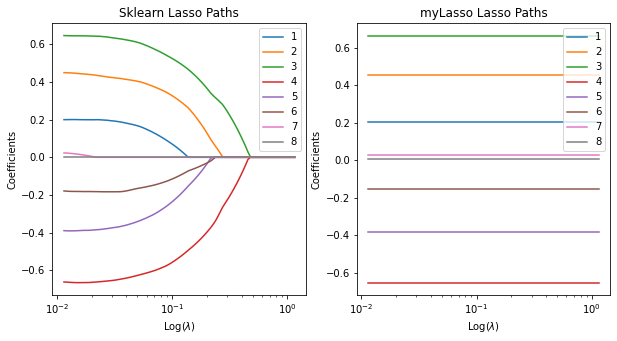

In [346]:
#Stack into numpy array
theta_sklearn = np.stack(theta_list).T
theta_myLasso = np.stack(b1_mylasso_pw).T

plt.subplots(2,2,figsize=(10,5)) 

plt.subplot(1, 2, 1)
for i in range(8):
    plt.plot(lamda_all, theta_sklearn[i], label = i+1)

plt.xscale('log')
plt.xlabel('Log($\\lambda$)')
plt.ylabel('Coefficients')
plt.title('Sklearn Lasso Paths')
plt.legend()

plt.subplot(1, 2, 2)
for i in range(8):
    plt.plot(lamda_all, theta_myLasso[i], label = i+1)
plt.xscale('log')
plt.xlabel('Log($\\lambda$)')
plt.ylabel('Coefficients')
plt.title('myLasso Lasso Paths')
plt.legend()

c) [5 pts] Based on your plot, if we decrease $\lambda$ from its maximum value, which two variables enter (start to have nonzero values) the model first? You may denote your covariates as $X_1, ..., X_8$. 

d) [5 pts] In Question 1, we calculated the L1 norm discrepancy between our solution and `glmnet` on the first 8 parameters. In this question, we will calculate the discrepancy on **all** coefficients, and over all $\lambda$ parameters. After calculating the discrepancies, show a scatter plot of  **log($\lambda$) vs. discrepancy**. Comment on what you observe.

In [ ]:
discrepancy = []
for j in range(len(lambda_seq)):
    discrepancy.append(sum([abs(a_i - b_i) for a_i, b_i in zip(sklearn_pw[j], mylasso_pw[j])]))

plt.scatter(discrepancy, np.log(lambda_seq))  
plt.title('scatter plot of log(𝜆) vs. discrepancy')
plt.ylabel('Discrepancy') 
plt.xlabel('Values of log(lambda)')
plt.show()

e) [15 pts] Based on the solution you obtained in the previous question, recover the unscaled coefficients using the formula in HW4. Then compare the first 9 coefficients (including the intercept term) with the following using a similar plot in b). Report the maximum value of discrepancy (see d) across all $\lambda$ values.

In [104]:
sd_X = np.std(X_org, axis=0)
mean_X = np.mean(X_org, axis=0)

# transformation of y_org
sd_y = np.std((y_org)
mean_y = np.mean(y_org)

# recovering the beta coefficients
b1_recover = scale_coeff*(sd_y/sd_X)
b0_recover = mean_y - sum(mean_X *scale_coeff*(sd_y/sd_X))

array([1.38629436, 1.60943791, 1.79175947])

In [ ]:
sklearn_unscaled= glmnet(X_org, y_org, lambda = lambda_all/2*sd(y_org)*sqrt(n/(n-1)))
sklearn_lasso_unscaled= coef(sklearn_unscaled)[1:9, ]

In [98]:
#Stack into numpy array
unscaled_theta_sklearn = np.stack(sklearn_unscaled).T
unscaled_theta_myLasso = np.stack(mylasso_unscaled).T

plt.subplots(2,2,figsize=(10,5)) 

plt.subplot(1, 2, 1)
for i in range(8):
    plt.plot(lamda_all, theta_sklearn[i], label = i+1)

plt.xscale('log')
plt.xlabel('Log($\\lambda$)')
plt.ylabel('Coefficients')
plt.title('Sklearn Unscaled Lasso Paths')
plt.legend()

plt.subplot(1, 2, 2)
for i in range(8):
    plt.plot(lamda_all, theta_myLasso[i], label = i+1)
plt.xscale('log')
plt.xlabel('Log($\\lambda$)')
plt.ylabel('Coefficients')
plt.title('myLasso Unscaled Lasso Paths')
plt.legend()

NameError: name 'sklearn_unscaled' is not defined